# Analysis

by Pete Schultz, Betzalel Moskowiz, Matt Griffith


### This notebook will contain the following analyses:
## **1. Exploratory Data Analysis with Descriptive Statistics**
- **Descriptive Statistics for combined 2017 and 2021 data**
    - Goal: Develop an understanding of the data, specifically for binary and year variables for the entire dataset
- **Descriptive Statistics for 2017 data**
    - Goal: Develop an understanding of the data, specifically for binary and year variables for the 2017 entries
- **Descriptive Statistics for 2021 data**
    - Goal: Develop an understanding of the data, specifically for binary and year variables for the 2021 entries
    
## **2. Topic Modeling Analysis of Full Job Description using LDA**
- **Topic Modeling Analysis of combined 2017 and 2021 data**
    - Goal: Understand what skills are and have been valuable for data and analyst related jobs
- **Topic Modeling Analysis of 2017 data**
    - Goal: Understand what skills were valuable for data and analyst related jobs in 2017
- **Topic Modeling Analysis of 2021 data**
    - Goal: Understand what skills are valuable for data and analyst related jobs in 2021
    
## **3. Analysis on the Data/Analyst Job Market**
- **Analysis of Remote Jobs**
    - Goal: Understand how the availability of remote jobs changed over time
- **Analysis of Companies**
    - Goal: Understand which companies are producing the greatest number of job listings on dice.com
- **Analysis of Employment Type**
    - Goal: Understand the percentage of jobs that are fulltime, contract, or other across all years and across each year
- **Analysis of Job Locations**
    - Goal: Understand which states have the most data/analyst related jobs

Import the necessary libraries for the analysis.

In [25]:
import regex as re
import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import warnings
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

#get rid of warnings
warnings.filterwarnings("ignore")

# visualizations
import matplotlib.pyplot as plt

Let's first load the data into dataframes.

In [2]:
#load the data
data2017 = pd.read_csv('/Users/Pete/Projects/Job_Analysis/2017_job_data.csv')
data2021 = pd.read_csv('/Users/Pete/Projects/Job_Analysis/2021_job_data.csv')

In order to analyze all of the data as a whole, we want to combine the two Datasets together from 2017 and 2021. All of the columns are the same in these two DataFrames except for the jobdescription section. We will have to rename these columns to have the same name before we can concatenate these dataframes together. We will also be combining the job description and skills column into one column called 'full_job_description' in order to ensure that we will have skills for as many observation as possible. This is necessary since companies are inconsistent and sometimes put the skills in the job description and other times put the skills in the skills field.

In [3]:
#rename the 'jobdescription' column in data2017 to 'job_description'
data2017 = data2017.rename(columns={'jobdescription': 'job_description'})
#concatenate the dataframes from 2017 to 2021 together
data = pd.concat([data2017, data2021])
#clean up the indices
data = data.set_index(['Unnamed: 0'], drop=True)
#create a new column that combines the text of job description and skills
data['full_job_description'] = data['job_description']+data['skills']
data.head()

,company,employmenttype_jobstatus,state,job_title,job_description,shift,skills,remote,full_time,contract,other,year,title,full_job_description
Unnamed: 0,,,,,,,,,,,,,,
11,CSI (Consultant Specialists Inc.),"Full Time, Contract Corp-To-Corp, Contract Ind...",CO,9001 Data Security Administrator - Unix & IAM,"Must have skills: UNIX, IAM (Identity Access M...",Telecommuting not available|Travel not required,"Unix, IAM, Scripting knowledge, OIM, Windows, ...",0.0,1.0,1.0,0.0,2017,NaN,"Must have skills: UNIX, IAM (Identity Access M..."
17,"VanderHouwen & Associates, Inc.","Full Time, Full time",OR,Principal Application Analyst-Supply Chain Lawson,VanderHouwen has more jobs you may like! Find...,Telecommuting not available|Travel not required,Lawson Supply Chain,0.0,1.0,0.0,0.0,2017,NaN,VanderHouwen has more jobs you may like! Find...
20,Genesis10,Full Time,GA,IT Business Analyst,Genesis10 is looking for a Business Analyst fo...,Telecommuting not available|Travel not required,"Analysis, Analyst, Application, Business Analy...",0.0,1.0,0.0,0.0,2017,NaN,Genesis10 is looking for a Business Analyst fo...
34,"VanderHouwen & Associates, Inc.","Contract W2, Contract",OR,Business Systems Analyst,VanderHouwen has more jobs you may like! Find ...,Telecommuting not available|Travel not required,"AI, Maya, Browzwear, 3D",0.0,0.0,1.0,0.0,2017,NaN,VanderHouwen has more jobs you may like! Find ...
42,Amazon,"Full Time, Fulltime",TX,"Software Development Engineer, Big Data",Do you want to help build a highly personalize...,Telecommuting not available|Travel not required,DESCRIPTION Do you want to help build a highly...,0.0,1.0,0.0,0.0,2017,NaN,Do you want to help build a highly personalize...


## 1. Exploratory Data Analysis with Descriptive Statistics

#### We will be running descriptive statistics to develop a better understanding of our data. The descriptive statistics will be run on the entire dataset in addition to the subsets of the dataset by year. 

### Descriptive Statistics for combined 2017 and 2021 data

The following code displays the descriptive statistics for the non-text data in the combined dataset of 2017 and 2021 data. Keep in mind that while all of the variables shown here are numeric, they are categorical variables. 

In [4]:
data.describe()

,remote,full_time,contract,other,year
count,7895.000000,7895.000000,7895.000000,7895.000000,7895.000000
mean,0.223559,0.571501,0.436859,0.064978,2019.333629
std,0.416656,0.494893,0.496029,0.246502,1.972102
min,0.000000,0.000000,0.000000,0.000000,2017.000000
25%,0.000000,0.000000,0.000000,0.000000,2017.000000
50%,0.000000,1.000000,0.000000,0.000000,2021.000000
75%,0.000000,1.000000,1.000000,0.000000,2021.000000
max,1.000000,1.000000,1.000000,1.000000,2021.000000


7895 observations

22% are remote, 57% are full time, 44% are contracting jobs, and about 25% are other (part time).

### Descriptive Statistics for 2017 data

The following code displays the descriptive statistics for the non-text data in the 2017 subset of the data. Keep in mind that while all of the variables shown here are numeric, they are categorical variables. 

In [5]:
data_2017 = data.loc[data.year==2017]
data_2017.describe()

,remote,full_time,contract,other,year
count,3289.000000,3289.000000,3289.000000,3289.000000,3289.0
mean,0.008817,0.537549,0.504409,0.065369,2017.0
std,0.093500,0.498664,0.500057,0.247214,0.0
min,0.000000,0.000000,0.000000,0.000000,2017.0
25%,0.000000,0.000000,0.000000,0.000000,2017.0
50%,0.000000,1.000000,1.000000,0.000000,2017.0
75%,0.000000,1.000000,1.000000,0.000000,2017.0
max,1.000000,1.000000,1.000000,1.000000,2017.0


3289 observations from 2017

0.8% are remote, 54% are full time, 50% are contracting jobs, and about 6% are other (part time)

### Descriptive Statistics for 2021 data

The following code displays the descriptive statistics for the non-text data in the 2021 subset of the data. Keep in mind that while all of the variables shown here are numeric, they are categorical variables. 

In [6]:
data_2021 = data.loc[data.year==2021]
data_2021.describe()

,remote,full_time,contract,other,year
count,4606.000000,4606.000000,4606.000000,4606.000000,4606.0
mean,0.376900,0.595745,0.388624,0.064698,2021.0
std,0.484662,0.490801,0.487490,0.246019,0.0
min,0.000000,0.000000,0.000000,0.000000,2021.0
25%,0.000000,0.000000,0.000000,0.000000,2021.0
50%,0.000000,1.000000,0.000000,0.000000,2021.0
75%,1.000000,1.000000,1.000000,0.000000,2021.0
max,1.000000,1.000000,1.000000,1.000000,2021.0


4606 observations from 2021

38% are remote, 60% are full time, 39% are contracting jobs, and about 6% are other (part time)

## 2. Topic Modeling Analysis of Full Job Description using LDA

#### We will be using Natural Language Processing to extract the skills from the `full_job_description` column. The idea is to create lda models and find the topic whose theme most closely relates to skills related to the job_description. We can then visualize these models to get an idea of which skills are most frequent in the skills topic to get an idea of what the most important and widely used skills were for that particular dataset.

###### The next two cells perform the necessary setup to both construct and visualize our LDA models.

In [7]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuation
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
def generate_lda_vis(data_words, topics):
    # Build the bigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops, bigram_mod)

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    doc_lda = lda_model[corpus]
    vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    return vis

### Topic Modeling Analysis of combined 2017 and 2021 data

The idea here is to look at all of the data from 2017 and 2021 to get an understand what the most relevant skills are for this time period.
For this, we can run an LDA model on the combined dataset of 2017 and 2021 and create a visualization that helps us to understand the most popular skills mentioned among job descriptions in both 2017 and 2021. This model will be run using 5 topics.

In [10]:
data_words_full = list(sent_to_words(data['full_job_description']))
generate_lda_vis(data_words_full, 5)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.065988  0.089282       1        1  46.460539
0      0.031977  0.232520       2        1  20.818560
3      0.014077 -0.093744       3        1  15.262821
1      0.221332 -0.158707       4        1  12.660613
2     -0.333374 -0.069351       5        1   4.797467, topic_info=         Term          Freq         Total Category  logprob  loglift
356     datum  24256.000000  24256.000000  Default  30.0000  30.0000
169  security  10415.000000  10415.000000  Default  29.0000  29.0000
28   business  25114.000000  25114.000000  Default  28.0000  28.0000
355      data   8462.000000   8462.000000  Default  27.0000  27.0000
113   network   4377.000000   4377.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
195      tool    650.979690   6436.745145   Topic5  -4.9357   0.7458
189    system    766.859580  19427.597433   Topic5  -4.7719  -0.1951
40   computer    561.178392   4578.642313   Topic5  -5.0842   0.9380
935   monitor    458.217284   1523.321827   Topic5  -5.2869   1.8358
172   service    476.537737  11101.967809   Topic5  -5.2477  -0.1112

[393 rows x 6 columns], token_table=       Topic      Freq                  Term
term                                        
23419      3  0.997311  abilities_aspiration
0          1  0.846729               ability
0          2  0.082758               ability
0          3  0.064994               ability
0          5  0.005531               ability
...      ...       ...                   ...
210        1  0.427544                  year
210        2  0.353064                  year
210        3  0.148162                  year
210        4  0.048348                  year
210        5  0.022856                  year

[700 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 4, 2, 3])

We can see that there are 5 topics here. 

Looking at topic 5, it looks like the theme of this topic appears to cyber-security and IT-related. Topics 1,3,4 seem to be more related to general employment, work environments, and job descriptions. It appears that the theme of topic 2 is most closely related to skills.

Setting the relevance λ = 0.01 (to sort almost exclusively by term frequency within the selected topic), we can see that the following skills appear to have the greatest estimated term frequecy within the the selected topic, meaning that the following skills appear to be the most in demand for jobs in both 2017 and 2021:

1. SQL
2. Python
3. Azure
4. ETL (likely extract, transform, and load tools)
5. AW (likely AWS)
6. Java
7. Warehouse (likely Data Warehousing)
8. Big (likely Big Data)
9. API
10. Tableau
11. Javascript
12. Visualization (likely data visualization)
13. Devop (likely DevOps)
14. Stack (likely full-stack development)
15. Pipeline (likely data pipeline)
16. Google (likely Google Cloud)
17. Relational (likely Relational Database)
19. Quantitative (likely quantitative skills)
20. Informatica
22. Hadoop
23. SSRS (likely SQL Server Reporting Services)
26. Stored_Procedure (likely in the context of databases)
28. Angular (likely Angular JS)
29. Machine Learning
30. Git

Note: Several entries are omitted in these rankings. These omitted entries are redundent or do not really apply to this topic.

### Topic Modeling Analysis of 2017 data

The idea here is to look at all of the data from 2017 to get an understand what the most relevant skills were for 2017.
For this, we can run an LDA model on the 2017 entries in the dataset and create a visualization that helps us to understand the most popular skills mentioned among job descriptions in 2017. This model will be run using 5 topics.

In [11]:
data_words_2017 = list(sent_to_words(data.loc[data['year']==2017]['full_job_description']))
generate_lda_vis(data_words_2017, 5)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.073300 -0.048209       1        1  35.022560
1     -0.070654 -0.121284       2        1  31.719332
3     -0.099232 -0.087726       3        1  16.418346
4      0.312461 -0.007830       4        1   9.332224
0     -0.069275  0.265049       5        1   7.507538, topic_info=              Term          Freq         Total Category  logprob  loglift
503          datum   9682.000000   9682.000000  Default  30.0000  30.0000
29        business  11148.000000  11148.000000  Default  29.0000  29.0000
170       security   2884.000000   2884.000000  Default  28.0000  28.0000
354           data   3355.000000   3355.000000  Default  27.0000  27.0000
190        support   6005.000000   6005.000000  Default  26.0000  26.0000
..             ...           ...           ...      ...      ...      ...
173        service    385.387681   3750.487931   Topic5  -4.9461   0.3139
225  configuration    255.440109    786.846215   Topic5  -5.3574   1.4642
210           work    280.727495   8417.971773   Topic5  -5.2630  -0.8115
320      technical    266.506907   4520.725297   Topic5  -5.3150  -0.2418
19     application    256.816787   4655.774287   Topic5  -5.3520  -0.3082

[384 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         1  0.619949     ability
0         2  0.325860     ability
0         3  0.045349     ability
0         5  0.008690     ability
754       2  0.996758  acceptance
...     ...       ...         ...
212       1  0.157088        year
212       2  0.460985        year
212       3  0.262589        year
212       4  0.038011        year
212       5  0.081259        year

[684 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 5, 1])

We can see that there are 5 topics here. 

Looking at topic 5, it looks like the theme of this topic appears to cyber-security and IT-related. Topics 1,2,4 seem to be more related to general employment, work environments, and job descriptions. It appears that topic 3 seems to be most related to job skills.

Setting the relevance λ = 0.01 (to sort almost exclusively by term frequency within the selected topic), we can see that the following skills appear to have the greatest estimated term frequecy within the the selected topic, meaning that the following skills appear to be the most in demand for jobs in 2017:

1. Big (likely Big Data)
2. ETL (likely extract, transform, and load tools)
3. Hadoop
4. Tableau
5. Spark (likely Apache Spark)
6. Informatica
7. Tera Data
8. NoSQL
9. Cassandra (likely Apache Cassandra)
10. SA (likely SAS)
11. Warehousing (likely data warehousing)
12. Scala
13. Algorithm
14. Hive
15. Pipeline (likely data pipeline)
16. Visualization (likely data visualization)
17. MySQL
19. HBase (likely Apache HBase)
20. Machine Learne (likely Machine Learning)
21. Datastage (likely IBM InfoSphere DataStage)
22. Python
25. SSIS (likely SQL Server Integration Services)
26. OBIEE (likely Oracle Business Intelligence Suite Enterprise Edition)
27. Predictive (likely predictive modeling)
28. AW (likely AWS)

Note: Several entries are omitted in these rankings. These omitted entries are redundent or do not really apply to this topic.

### Topic Modeling Analysis of 2021 data

The idea here is to look at all of the data from 2021 to get an understand what the most relevant skills are today in 2021.
For this, we can run an LDA model on the 2021 entries in the dataset and create a visualization that helps us to understand the most popular skills mentioned among job descriptions in 2021. This model will be run using 5 topics.

In [12]:
data_words_2021 = list(sent_to_words(data.loc[data['year']==2021]['full_job_description']))
generate_lda_vis(data_words_2021, 5)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.145884 -0.012663       1        1  37.486075
1      0.076548 -0.017778       2        1  22.806856
3      0.115646 -0.172533       3        1  18.986519
2      0.019480  0.253917       4        1  17.607057
0     -0.357558 -0.050942       5        1   3.113492, topic_info=            Term          Freq         Total Category  logprob  loglift
23         datum  11068.000000  11068.000000  Default  30.0000  30.0000
292     security   7340.000000   7340.000000  Default  29.0000  29.0000
124      analyst   5859.000000   5859.000000  Default  28.0000  28.0000
9       business  17172.000000  17172.000000  Default  27.0000  27.0000
127          api   3685.000000   3685.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
5          apply    262.791113   2067.594517   Topic5  -4.9232   1.4066
1373      agency    223.047808   1238.683021   Topic5  -5.0871   1.7550
982    candidate    264.760066   2471.291126   Topic5  -4.9157   1.2358
35    experience    333.747177  19342.289666   Topic5  -4.6841  -0.5902
406     position    208.587579   3642.190092   Topic5  -5.1542   0.6094

[393 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
2621      3  0.996491  abilities_aspiration
109       1  0.728976               ability
109       2  0.175408               ability
109       3  0.079613               ability
109       4  0.015997               ability
...     ...       ...                   ...
108       2  0.089841                  year
108       3  0.193706                  year
108       4  0.286907                  year
108       5  0.015631                  year
6923      1  0.995990       yearsexperience

[696 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 3, 1])

We can see that there are 5 topics here.

Looking at topic 3, it looks like the theme of this topic appears to cyber-security and IT-related. Topics 1,2,5 seem to be more related to general employment, work environments, and job descriptions. It appears that topic 4 seems to be most related to job skills.

Setting the relevance λ = 0.01 (to sort almost exclusively by term frequency within the selected topic), we can see that the following skills appear to have the greatest estimated term frequecy within the the selected topic, meaning that the following skills appear to be the most in demand for jobs in 2021:

1. API
2. SOA
3. Azure
4. Java
5. Python
6. AW (likely AWS)
7. Devop (likely DevOps)
8. Native 
9. Angular (likely Angular JS)
10. Javascript
11. Big (likley big data)
13. Microservices
14. Apex
15. JSON
16. Stack (likely full-stack development)
18. Relational (likely Relational Database)
19. AEM (likely Adobe Experience Manager)
20. Pattern (likely pattern detection or pattern database)
21. HTML
22. Apigee (likely Apigee API)
26. Stored_Procedure (likely in the context of databases)
28. Informatica
29. App (likely application development)
30. Kubernete

Note: Several entries are omitted in these rankings. These omitted entries are redundent or do not really apply to this topic.

## Results from Topic Modeling Analysis of Full Job Description using LDA: 
### It appears that the most relevant skills over the last 4 years are:
##### 1. SQL
##### 2. Python
##### 3. Azure
##### 4. ETL (likely extract, transform, and load tools)
##### 5. AW (likely AWS)
##### 6. Java
##### 7. Warehouse (likely Data Warehousing)
##### 8. Big (likely Big Data)
##### 9. API
##### 10. Tableau

 
 

### There are many differences between the 2017 skills and 2021 skills. Here are a couple insights that we can take back from the data:
##### 1. Python has become much more desirable
##### 2. Knowing how to work with Big Data has been and continues to be very desirable
##### 3. Cloud Computing tools like Azure and AWS have become a lot more desirable
##### 4. Knowing how to work with databases (MySQL, NoSQL, etc.) has been and continues to be extremely desirable
##### 5. Front-end web tools like HTML, JavaScript, AngularJS in addition to data visualization tools like Tableau have become increasingly desirable skills

## 3. Analysis on the Data/Analyst Job Market

### The remaining analysis will be conducted on the following:

- **Analysis of Remote Jobs**
    - Goal: Understand how the availability of remote jobs changed over time
- **Analysis of Companies**
    - Goal: Understand which companies are producing the greatest number of job listings on dice.com
- **Analysis of Employment Type**
    - Goal: Understand the percentage of jobs that are fulltime, contract, or other across all years and across each year
- **Analysis of Job Locations**
    - Goal: Understand which states have the most data/analyst related jobs

### Analysis of Remote Jobs

To analyze remote jobs, I will be computing the percentage of jobs that were remote in both 2017 and 2021 in addition to all observations. I will then be plotting these percentages to better visualize the results.

In [13]:
remote_all = data.loc[data.remote == 1].shape[0]*100/data.shape[0]
remote_2017 = data_2017.loc[data_2017.remote ==1].shape[0]*100/data_2017.shape[0]
remote_2021 = data_2021.loc[data_2021.remote ==1].shape[0]*100/data_2021.shape[0]
pd.DataFrame({'Percent_Remote': [remote_2017, remote_2021, remote_all]}, index=['2017', '2021', 'All'])

,Percent_Remote
2017,0.881727
2021,37.689970
All,22.355921


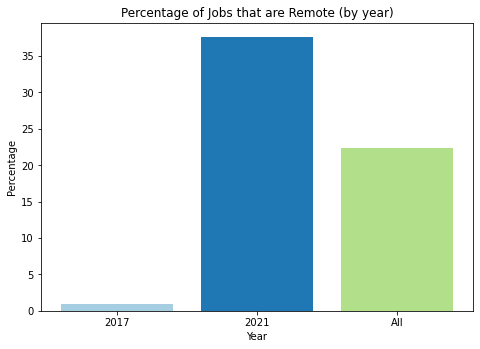

In [14]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
years = ['2017', '2021', 'All']
remote_percentages = [remote_2017, remote_2021, remote_all]
ax.bar(years,remote_percentages, color=plt.cm.Paired(np.arange(len(years))))
ax.set_ylabel('Percentage')
ax.set_xlabel('Year')
ax.set_title('Percentage of Jobs that are Remote (by year)')
plt.show()

From this visualization, we can see that the number of remote jobs was way up in 2021, likely due to the COVID-19 pandemic.

### Analysis of Companies

To analyze the companies who are posting these job descriptions, I will be determining the top 10 companies by number of job postings on dice.com. The following are the top 10 companies by number of job postings.

In [15]:
top_10_companies_counts = data.company.value_counts()[:10]
top_10_companies_counts

Data Systems Analysts Inc. (DSA)    155
Apex Systems                        155
Motion Recruitment                  131
Leidos                              125
Deloitte                            115
Kforce Technology Staffing          104
Judge Group, Inc.                   100
Perspecta                            90
Robert Half                          81
Anthem, Inc                          62
Name: company, dtype: int64

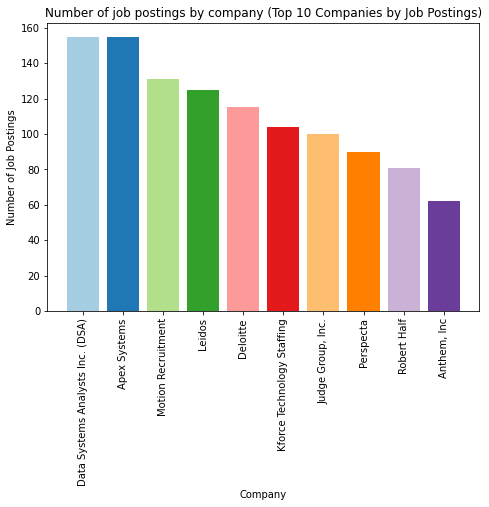

In [19]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
companies = top_10_companies_counts.index.to_list()
counts = top_10_companies_counts
ax.bar(companies, counts, color=plt.cm.Paired(np.arange(len(top_10_companies_counts))))
ax.set_ylabel('Number of Job Postings')
ax.set_xlabel('Company')
ax.set_title('Number of job postings by company (Top 10 Companies by Job Postings)')
plt.xticks(rotation=90)
plt.show()

### Analysis of Employment Type

There are three types of employment in this dataset:
1. Full-time
2. Contract
3. Other (part time, internship, co-op, etc.)

We want to analyze how employment type has changed overtime among job postings.

In [20]:
full_time_2017 = data_2017.full_time.sum()
full_time_2021 = data_2021.full_time.sum()
total_full_time = data.full_time.sum()
contract_2017 = data_2017.contract.sum()
contract_2021 = data_2021.contract.sum()
total_contract = data.contract.sum()
other_2017 = data_2017.other.sum()
other_2021 = data_2021.other.sum()
total_other = data.other.sum()
employment_type_counts = pd.DataFrame({'Full_Time': [full_time_2017,full_time_2021, total_full_time], 
              'Contract': [contract_2017, contract_2021, total_contract],
              'Other':[other_2017, other_2021, total_other]}, index=['2017', '2021', 'All'])
employment_type_counts

,Full_Time,Contract,Other
2017,1768.0,1659.0,215.0
2021,2744.0,1790.0,298.0
All,4512.0,3449.0,513.0


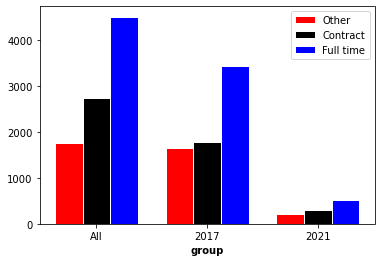

In [21]:
years = ['2017', '2021', 'All']

# set width of bars
barWidth = 0.25
 
# set heights of bars
bars1 = employment_type_counts.loc['2017']
bars2 = employment_type_counts.loc['2021']
bars3 = employment_type_counts.loc['All']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='red', width=barWidth, edgecolor='white', label='Other')
plt.bar(r2, bars2, color='black', width=barWidth, edgecolor='white', label='Contract')
plt.bar(r3, bars3, color='blue', width=barWidth, edgecolor='white', label='Full time')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['All', '2017', '2021'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

The visualization shows that in general there are more full-time positions than contracts and other positions. This appears to be true across all job listings, especially in 2017 but a little less so in 2021.

### Analysis of Job Locations

To analyze job locations, I will count the number of job listings by state. However, some of the states are written out, so we need to make sure that they are all in their code form. Finally, I will create a data visualization to help better visualize the information.

In [22]:
#needs to be cleaned
s_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}


In [23]:
#convert states to abbreviate codes, strip whitespaces, and get counts of each state
states = pd.DataFrame(data.state)
state_counts = {}
for state in states.state:
    stripped_state = str(state).replace(' ','')
    if stripped_state.lower().capitalize() in s_state_abbrev:
        stripped_state = s_state_abbrev[stripped_state.lower().capitalize()]
    if stripped_state not in state_counts:
        state_counts[stripped_state] = 1
    else:
        state_counts[stripped_state] += 1
#get the top 10 states by number of job postings
state_counts_df = pd.DataFrame(state_counts, index=['Count']).T.sort_values(by='Count', ascending=False)[:10]
state_counts_df

,Count
CA,1130
TX,617
NY,566
REMOTE,514
VA,507
NJ,414
GA,412
MA,319
PA,318
MD,290


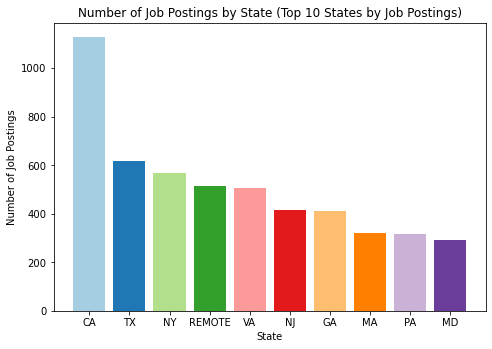

In [24]:
#Plot the results
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
states = state_counts_df.index.to_list()
s_counts = state_counts_df['Count']
ax.bar(states, s_counts, color=plt.cm.Paired(np.arange(len(state_counts_df))))
ax.set_ylabel('Number of Job Postings')
ax.set_xlabel('State')
ax.set_title('Number of Job Postings by State (Top 10 States by Job Postings)')
plt.xticks()
plt.show()

From here we can see that the top 10 states with the greatest number of job postings are CA, TX, NY, REMOTE, VA, NJ, GA, MA, PA, and MD.